# Targeted protein quantification from list of targets generated in R
needed to use R for peptide-to-protein mapping, jump back here to do quant because it is much faster

In [506]:
from pyteomics import mgf
from pyteomics import mzxml
from pyteomics import mass

import pandas as pd
import numpy as np
import re
import pickle
import timeit
import time

import matplotlib.pyplot as plt
from pylab import rcParams

### Functions to match intensities, m/z, and to get quant frags from the target table

In [508]:
# to extract the int values between two other values
def getFragInt(pred_mass, mz_list, int_list, tol, tol_type):
    ''' 
    PURPOSE:
    Find observed intensity for theoretical m/z value in spectra
    
    INPUTS:
    pred_mass = the theoretical mass of the fragment ion
    mz_array = numpy array of all peak masses in the spectra
    int_array = numpy array of all peak intensities in the spectra
    ppm = the mass tolerance for the fragments in ppm
    noiselevel = value to be subtracted from each value
    
    OUTPUTS:
    numpy array containing the intensity for any m/z found
    
    '''
    if tol_type=="ppm":
        lowmz = pred_mass - pred_mass*tol
        highmz = pred_mass + pred_mass*tol
    if tol_type == "abs":
        lowmz = pred_mass - tol
        highmz = pred_mass + tol
    found = [int_list[index] for index, value in enumerate(mz_list) if value>lowmz and value<highmz]
    #found = found-noiselevel
    if len(found)==0:
        found = [1]
    return(found[0])

In [509]:
# function to get the quant frag table from the line in the target table
def getQuantFragsFromTargetList(target_table, line):
    tmpline = target_table.iloc[line]
    if(len(tmpline['ylight'])>1):
        output= pd.DataFrame( {'lightmz':[float(x) for x in tmpline['ylight']], 
                   'heavymz':[float(x) for x in tmpline['yheavy']]})
    if(len(tmpline['ylight'])<2):
        print(str(tmpline['Peptide'])+'not enough fragments')
        output = 'not enough fragments'
    return(output)

# For most intense peptide set - need to match peptide targets to scans

### Import the quant target table from R

In [510]:
qtargs2 = pd.read_csv("P:/JGM_DI2A/R/outputs/mostintense_quantmzlist.txt", sep="\t",
                          converters={"ylight": lambda x: x.strip("[]").split(", "),
                                     "yheavy": lambda x: x.strip("[]").split(", "), 
                                     "yordinals": lambda x: x.strip("[]").split(", ")})

In [511]:
target_scan_ids = [(qtargs2['prec_light_mz'][x], qtargs2['prec_heavy_mz'][x], qtargs2['CV'][x]) for x in range(len(qtargs2))]

In [512]:
len(target_scan_ids)

552

In [513]:
### makes a dict of scan:CV value pairs for lookup of the CV
tmp_prec_dict = {}
with mzxml.read("P:/JGM_DI2A/MSDATA/20190501_DI2A_IT_MS1/20190503_DI2A_tMS2_OTmostint_A549_1to1_01.mzXML") as spectra:
    for x in spectra:
        tmp_prec_dict[round(x['precursorMz'][0]['precursorMz'], 2), 
                                   round(x['precursorMz'][1]['precursorMz'], 2), 
                                  x['compensationVoltage']] = x['num']

In [514]:
## fix the numbering of which scan each peptide should be quantified from because the table has decoys left in it
quant_scan = []
for x in target_scan_ids:
    quant_scan.append(tmp_prec_dict[(x)])
qtargs2['quantscan'] = quant_scan

In [515]:
fileslist = [
    "P:/JGM_DI2A/MSDATA/20190501_DI2A_IT_MS1/20190503_DI2A_tMS2_OTmostint_A549_1to8_01.mzXML",
    "P:/JGM_DI2A/MSDATA/20190501_DI2A_IT_MS1/20190503_DI2A_tMS2_OTmostint_A549_1to4_01.mzXML",
    "P:/JGM_DI2A/MSDATA/20190501_DI2A_IT_MS1/20190503_DI2A_tMS2_OTmostint_A549_1to2_01.mzXML",
    "P:/JGM_DI2A/MSDATA/20190501_DI2A_IT_MS1/20190503_DI2A_tMS2_OTmostint_A549_1to1_01.mzXML",
    "P:/JGM_DI2A/MSDATA/20190501_DI2A_IT_MS1/20190503_DI2A_tMS2_OTmostint_A549_2to1_01.mzXML",
    "P:/JGM_DI2A/MSDATA/20190501_DI2A_IT_MS1/20190503_DI2A_tMS2_OTmostint_A549_4to1_01.mzXML",
    "P:/JGM_DI2A/MSDATA/20190501_DI2A_IT_MS1/20190503_DI2A_tMS2_OTmostint_A549_8to1_01.mzXML"
]

## Use fragments from qtargs2

In [516]:
resultsdict = {}
stt = time.time()
TOL_TYPE = "ppm"
TOL = 10e-6

for k in fileslist:
    meanratio_list = []
    medianratio_list= []
    matchdf_list = []
    quantscans = qtargs2['quantscan']
    with mzxml.read(k, use_index =True) as tmpquantfile:
        #quantscans = sortedpepdf['quantscans'].tolist()
        peplist = qtargs2['Peptide'].tolist()
        #specnamelist = sortedpepdf['Name'].tolist()
        looplen = len(qtargs2)
        st = time.time()
        for i in range(0, looplen):
            #print(i)
            #sts = time.time()
            tmp_qf = getQuantFragsFromTargetList(qtargs2, i)
            if(type(tmp_qf)!=str):
                tmpmzarray = tmpquantfile.get_by_id(quantscans[i])['m/z array'].tolist()
                tmpintarray = tmpquantfile.get_by_id(quantscans[i])['intensity array'].tolist()
                lightints = [getFragInt(x, tmpmzarray, tmpintarray, TOL, TOL_TYPE) for x in tmp_qf['lightmz']]
                heavyints = [getFragInt(x, tmpmzarray, tmpintarray, TOL, TOL_TYPE) for x in tmp_qf['heavymz']]
                ratios = [x/y for x,y in zip(heavyints, lightints)]
                tmp_qf['lightint'] = lightints
                tmp_qf['heavyint'] = heavyints
                tmp_qf['HLratios'] = ratios
                matchdf_list.append(tmp_qf)
                
                intsum = [sum(x) for x in zip(heavyints, lightints)]
                rm = [index for index, value in enumerate(intsum) if value==2] # get index of values that are both 1 
                for x in sorted(rm, reverse=True):
                    del lightints[x]
                    del heavyints[x]
                rm0ratios = [x/y for x,y in zip(heavyints, lightints)]
                # if there is at least one fragment matched, compute ratio and append to lists
                if len(rm0ratios)>0:
                    meanratio_list.append(np.mean(rm0ratios))
                    medianratio_list.append(np.median(rm0ratios))
                #print('time for 1 spec= '+str(time.time()-sts))
        print('file= '+k+', quantified '+str(looplen/(time.time()-st))+' spectra per second')
    resultsdict[k] = [matchdf_list, medianratio_list, meanratio_list]
print(time.time()-stt)

GLGLSPDLIVC+57.0215Rnot enough fragments
DIALVQQLFEALC+57.0215Knot enough fragments
LTAQEAC+57.0215GKnot enough fragments
EASIC+57.0215ALRnot enough fragments
file= P:/JGM_DI2A/MSDATA/20190501_DI2A_IT_MS1/20190503_DI2A_tMS2_OTmostint_A549_1to8_01.mzXML, quantified 312.5355438516539 spectra per second
GLGLSPDLIVC+57.0215Rnot enough fragments
DIALVQQLFEALC+57.0215Knot enough fragments
LTAQEAC+57.0215GKnot enough fragments
EASIC+57.0215ALRnot enough fragments
file= P:/JGM_DI2A/MSDATA/20190501_DI2A_IT_MS1/20190503_DI2A_tMS2_OTmostint_A549_1to4_01.mzXML, quantified 320.6838756770495 spectra per second
GLGLSPDLIVC+57.0215Rnot enough fragments
DIALVQQLFEALC+57.0215Knot enough fragments
LTAQEAC+57.0215GKnot enough fragments
EASIC+57.0215ALRnot enough fragments
file= P:/JGM_DI2A/MSDATA/20190501_DI2A_IT_MS1/20190503_DI2A_tMS2_OTmostint_A549_1to2_01.mzXML, quantified 330.24531848748666 spectra per second
GLGLSPDLIVC+57.0215Rnot enough fragments
DIALVQQLFEALC+57.0215Knot enough fragments
LTAQEAC+5

In [517]:
allmedians = []
allmeans = []
for x in fileslist:
    tmpmedians = resultsdict[x][1]
    tmpmeans = resultsdict[x][2]
    allmedians.append([np.log2(x) for x in tmpmedians if type(x) != list ])
    allmeans.append([np.log2(x) for x in tmpmeans if type(x) != list ])
print('number of peptides (proteins) quantified')
for x in allmedians:
    print(len(x))

number of peptides (proteins) quantified
525
511
501
490
497
500
486


In [518]:
allmedianslonglist = []
allmeanslonglist = []
for x in fileslist:
    tmpmedians = resultsdict[x][1]
    tmpmeans = resultsdict[x][2]
    #tmpval[np.log2(y) for y in tmpmedians if type(y) != list ] 
    allmedianslonglist = allmedianslonglist + [np.log2(y) for y in tmpmedians if type(y) != list ]
    allmeanslonglist = allmeanslonglist + [np.log2(y) for y in tmpmeans if type(y) != list ]
i=1
xvals = []
for x in allmedians:
    xvals = xvals +[i]*len(x)
    i+=1

# Make figure 3 panel C

(-13, 13)

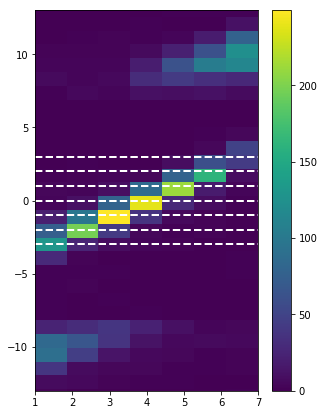

In [520]:
rcParams['figure.figsize'] = 5, 7
fig, ax = plt.subplots()

h = ax.hist2d(np.array(xvals), np.asarray(allmedianslonglist), bins=[7,31], )
#plt.ylim(-6,6)
plt.colorbar(h[3], ax=ax)
plt.plot([1,7], [np.log2(8/1), np.log2(8/1)], color='w', linestyle='--', linewidth=2)
plt.plot([1,7], [np.log2(4/1), np.log2(4/1)], color='w', linestyle='--', linewidth=2)
plt.plot([1,7], [np.log2(2/1), np.log2(2/1)], color='w', linestyle='--', linewidth=2)
plt.plot([1,7], [np.log2(1/1), np.log2(1/1)], color='w', linestyle='--', linewidth=2)
plt.plot([1,7], [np.log2(1/2), np.log2(1/2)], color='w', linestyle='--', linewidth=2)
plt.plot([1,7], [np.log2(1/4), np.log2(1/4)], color='w', linestyle='--', linewidth=2)
plt.plot([1,7], [np.log2(1/8), np.log2(1/8)], color='w', linestyle='--', linewidth=2)
plt.ylim(-13,13)
#plt.savefig('P:/JGM_DI2A/Python/outputs/heatmap10ppm_top3_1_ion.svg', type='svg')
#plt.xlabel(['8:1', '4:1', '2:1'])
#plt.title('20ppm, at least one ion from top3')